In [16]:
from gerrychain import Graph

In [17]:
# Read New Mexico county graph from 'COUNTY_35.json'
filename = 'COUNTY_35.json'

# Use built-in GerryChain function to read graph
G = Graph.from_json(filename )

In [18]:
# Impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 682962 and U = 689824 and k = 3


In [19]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# set variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

In [20]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [21]:
# add constraint: each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraint: each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraint: edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [22]:
# Add contiguity constraints and re-solve the model.
# Using the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG
import networkx as nx
DG = nx.DiGraph(G) # directed version of G
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)

In [23]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )  

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in G.nodes)

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in G.edges )

m.update()

In [24]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 486 rows, 432 columns and 1941 nonzeros
Model fingerprint: 0x555f929d
Variable types: 156 continuous, 276 integer (276 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve time: 0.01s
Presolved: 486 rows, 432 columns, 1932 nonzeros
Variable types: 156 continuous, 276 integer (276 binary)

Root relaxation: objective 2.000000e+00, 166 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.00000    0  110          -    3.00000      -     -    0s
     0     0    3.79118    0  113          -    3.79118      -     -    0s
     0     0    6.71894    0  125          -    6.71894    

In [11]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The number of cut edges is 17.0
District 0 has population 683772 and contains counties ['Harding', 'Guadalupe', 'San Juan', 'Curry', 'Taos', 'Quay', 'Colfax', 'Los Alamos', 'Rio Arriba', 'San Miguel', 'Sandoval', 'Santa Fe', 'McKinley', 'Mora', 'Union']
District 1 has population 685630 and contains counties ['Sierra', 'Lea', 'Torrance', 'Grant', 'Otero', 'Roosevelt', 'Hidalgo', 'Eddy', 'De Baca', 'Doña Ana', 'Chaves', 'Valencia', 'Catron', 'Socorro', 'Lincoln', 'Luna']
District 2 has population 689777 and contains counties ['Cibola', 'Bernalillo']


In [12]:
# Draw it on a map
import geopandas as gpd

In [13]:
# Read New Mexico county shapefile from "NM_counties.shp"
filename = 'NM_counties.shp'

# Read geopandas dataframe from file
df = gpd.read_file(filename )

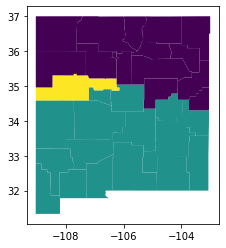

In [14]:
# Assign each county to a district
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(k):
    
    # for each node i in this district
    for i in districts[j]:
        
        # determine its GEOID
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()